# Problem-2
Analyze the unit cell parameters of proteins and protein-protein complexes in the PDB.

In [14]:
from pyspark import SparkContext
from pyspark.sql import Row, SparkSession
from mmtfPyspark.filters import ContainsLProteinChain
from mmtfPyspark.ml import pythonRDDToDataset
from mmtfPyspark.io import mmtfReader
import matplotlib.pyplot as plt

%matplotlib inline

#### Configure Spark Session and Spark Context

In [2]:
spark = SparkSession.builder.master("local[4]").appName("Problem-2").getOrCreate()
sc = spark.sparkContext

#### Read a  sample of the PDB

In [3]:
path = "../resources/mmtf_full_sample"
pdb = mmtfReader.read_sequence_file(path, sc)

### TODO-1 Restrict the analysis to proteins only

In [4]:
pdb = pdb.filter(ContainsLProteinChain())

### Remove structures without unit cell data

In [5]:
pdb = pdb.filter(lambda t: t[1].unit_cell != None)

### TODO-2 Define method to create a Row with unit cell data

In [6]:
def calcProperties(s):
    structure_id = s[0]
    space_group = s[1].space_group
    a, b, c, alpha, beta, gamma = s[1].unit_cell

    return Row(structure_id, space_group, a, b, c, alpha, beta, gamma)

### TODO-3: Map structures to properties

In [7]:
rows = pdb.map(lambda s: calcProperties(s))

### TODO-4: Create a dataset from the RDD

In [8]:
col_names = ["structureId", "spaceGroup", "a", "b", "c", "alpha", "beta", "gamma"]
summary = pythonRDDToDataset.get_dataset(rows, col_names) 

## Done: Show some details about this dataset

In [9]:
summary.columns

['structureId', 'spaceGroup', 'a', 'b', 'c', 'alpha', 'beta', 'gamma']

In [10]:
summary.printSchema()

root
 |-- structureId: string (nullable = false)
 |-- spaceGroup: string (nullable = false)
 |-- a: float (nullable = false)
 |-- b: float (nullable = false)
 |-- c: float (nullable = false)
 |-- alpha: float (nullable = false)
 |-- beta: float (nullable = false)
 |-- gamma: float (nullable = false)



In [11]:
summary.toPandas().head(10)

,structureId,spaceGroup,a,b,c,alpha,beta,gamma
0,1RCQ,C 2 2 21,72.679001,76.128998,136.266006,90.0,90.000000,90.0
1,1REG,P 21 21 21,82.708000,85.724998,43.485001,90.0,90.000000,90.0
2,1RFE,P 43 2 2,49.308998,49.308998,132.587997,90.0,90.000000,90.0
3,1RG8,C 2 2 21,74.260002,96.209000,108.956001,90.0,90.000000,90.0
4,1RGX,C 1 2 1,49.021000,52.474998,96.609001,90.0,96.529999,90.0
5,1RH6,C 1 2 1,80.214996,72.691002,38.800999,90.0,104.110001,90.0
6,1RI5,P 31 2 1,63.772999,63.772999,112.778000,90.0,90.000000,120.0
7,1RI6,P 21 21 21,57.984001,61.590000,88.635002,90.0,90.000000,90.0
8,1RIF,P 1 21 1,42.738998,95.181000,86.278000,90.0,95.400002,90.0
9,1RJD,P 65,110.682999,110.682999,165.878998,90.0,90.000000,120.0


## Group data by space group and count occurances

In [12]:
df = summary.groupBy("spaceGroup")\
            .count()\
            .sort("count", ascending=False)\
            .toPandas()

df.head(10)

,spaceGroup,count
0,P 21 21 21,2211
1,P 1 21 1,1595
2,C 1 2 1,1076
3,P 21 21 2,558
4,C 2 2 21,544
5,P 1,417
6,P 41 21 2,324
7,P 43 21 2,313
8,P 32 2 1,281
9,P 31 2 1,262


## Plot histogram for the top 10 space groups

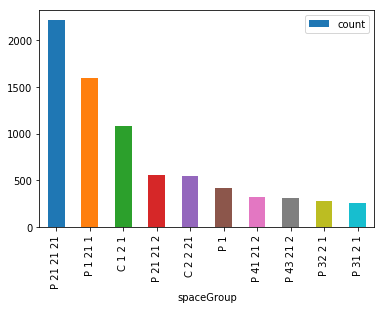

In [15]:
df.head(10).plot(x='spaceGroup', y='count', kind='bar');

In [16]:
spark.stop()